# Write a Blog Post
## Introduction
This blog post will investigate the effects of entertainment events vs baseline on Airbnb properties using the Boston dataset.





In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import folium
import math
%matplotlib inline

calendar_df = pd.read_csv('./calendar.csv')
listing_df = pd.read_csv('./listings.csv')
review_df = pd.read_csv('./reviews.csv')




In [3]:
#calendar_df.head()
listing_df.head()
#review_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [4]:
for i in listing_df:
    print(i)

id
listing_url
scrape_id
last_scraped
name
summary
space
description
experiences_offered
neighborhood_overview
notes
transit
access
interaction
house_rules
thumbnail_url
medium_url
picture_url
xl_picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_listings_count
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
street
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
city
state
zipcode
market
smart_location
country_code
country
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
amenities
square_feet
price
weekly_price
monthly_price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
calendar_updated
has_availability
availability_30
availability_60
availability_90
availability_365
cal

In [6]:
### Investigate the property_type
property_types = set(listing_df['property_type'])
property_types

{nan,
 'Other',
 'Boat',
 'Dorm',
 'Loft',
 'Villa',
 'Apartment',
 'House',
 'Bed & Breakfast',
 'Townhouse',
 'Condominium',
 'Guesthouse',
 'Entire Floor',
 'Camper/RV'}

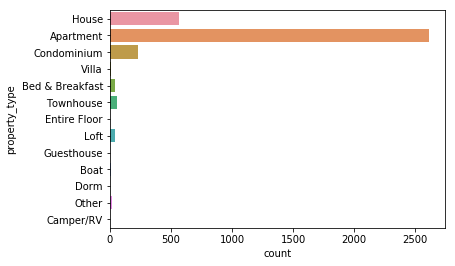

In [12]:
sns.countplot(data = listing_df, y="property_type")

### Distance to Fenway park

- Fenway park is located at 42°20′46.5″N, 71°5′51.9″W [according to Wikipedia]
- At 42° N, a degree of latitude is 111073.25426300173 m
- At 42° N, a degree of longitude is 82850.73126783255 m [according to http://www.csgnetwork.com/degreelenllavcalc.html]


In [31]:
#Converting minutes and seconds to decimal degrees, this is:
fenway_latitude = 42 + 20/60 + 46.5/3600
fenway_longitude = -1 * (71 + 5/60 + 51.9/3600)

print("Fenway is at: <" + str(fenway_latitude) + " N, " +  str(fenway_longitude) + " W>")

Fenway is at: <42.346250000000005 N, -71.09774999999999 W>


In [16]:
listing_df[['id','latitude','longitude']].head(10)

,id,latitude,longitude
0,12147973,42.282619,-71.133068
1,3075044,42.286241,-71.134374
2,6976,42.292438,-71.135765
3,1436513,42.281106,-71.121021
4,7651065,42.284512,-71.136258
5,12386020,42.291690,-71.131893
6,5706985,42.281390,-71.131190
7,2843445,42.281946,-71.141022
8,753446,42.285878,-71.124910
9,849408,42.288820,-71.139510


In [29]:
'''
distance_to_fenway

Inputs: latitude, longitude of a point on the earth's surface (in decimal degrees)
Outputs: the euclidean distance from the point to Fenway Park in Boston, 
         approximating the Earth as a plane, in meters

'''
def distance_to_fenway(lat, lon):
    lat_dist = lat - fenway_latitude
    long_dist = lon - fenway_longitude
    #convert to meters
    x_dist = lat_dist * 111073.25426300173
    y_dist = long_dist * 82850.73126783255
    #find euclidean distance
    dist = math.sqrt(x_dist**2 + y_dist**2)
    return dist   
    
    

In [32]:
distance_to_fenway(listing_df['latitude'][0], listing_df['longitude'][0])

7649.502726300465